In [75]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import cartopy
from cartopy import crs as ccrs

from copy import copy

%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom

/home/mikhail/.virtualenvs/default/local/lib/python2.7/site-packages/matplotlib/ticker.py:1684: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [18]:
WLON = -20
ELON = 45
LON_0 = (WLON + ELON) / 2.

12.5


In [74]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

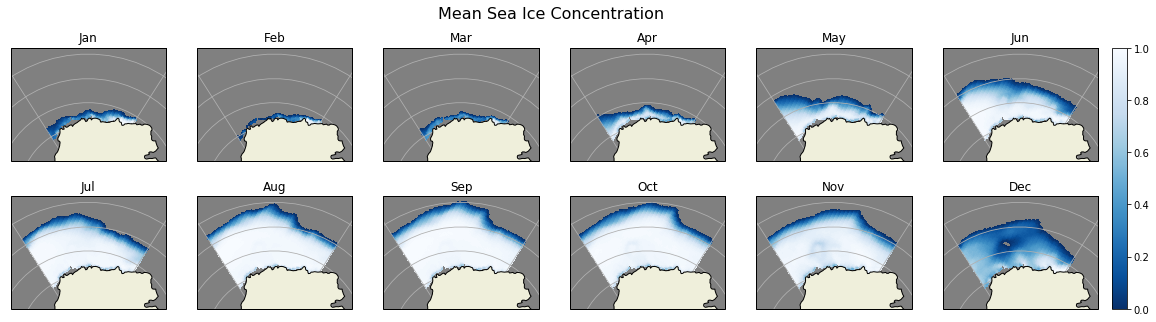

In [162]:
def map_monthly_mean(filepath, months=None, dml_mask=True):
    """
    Plot sea ice concentration of mean monthly SIC values for the last 30 years
    """
    plt.clf()
    if months:
        idxs = range(12)
    
    
    month_list = ["Jan",
                  "Feb",
                  "Mar",
                  "Apr",
                  "May",
                  "Jun",
                  "Jul",
                  "Aug",
                  "Sep",
                  "Oct",
                  "Nov",
                  "Dec"]
    
    dst = nc.Dataset(filepath, 'r')
    sic = dst.variables['goddard_merged_seaice_conc_monthly'][:]
    cmap = 'Blues_r'
    
    
    if dml_mask:
        lons = dst.variables['longitude'][:]
        lats = dst.variables['latitude'][:]
        lon_mask = (lons >= 45) + (lons <= -20)
        sic = np.ma.array(sic, mask=np.tile(lon_mask, (sic.shape[0],1)))
        sic = np.ma.array(sic, mask=sic.mask+sic.data<0.15)
    
    m = 6; k = 2
    fig, axarr = plt.subplots(k, m, figsize=(20,5),
                            subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=LON_0)})
    i= 0; j=0
    
    for idx in idxs:
        if idx<m*k/2:
            i = 0; j = idx
        else:
            i = 1; j = idx - m
       
        ax = axarr[i,j]
        ax.background_patch.set_facecolor('gray')
        ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
        ax.set_extent([-2281850, 2304587, 1000000, 4346774], crs=ccrs.SouthPolarStereo(central_longitude=LON_0))
        #ax.coastlines()
        ax.pcolormesh(lons,lats,sic[idx], cmap='Blues_r', transform=ccrs.PlateCarree())
        # Define gridline locations and draw the lines using cartopy's built-in gridliner:
        ax.gridlines(xlocs=[WLON-50,WLON,ELON,ELON+50])
        ax.set_title(month_list[idx])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(0,1))
    sm._A = []
    #plt.colorbar(sm,ax=ax)
    
    
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.89, 0.14, 0.01, 0.725])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    plt.suptitle('Mean Sea Ice Concentration', fontsize=16)
    plt.show()

    
filepath = "/media/DataLocal/Projects/DmlEnvironmentState/data/anomalies/monthly_seaice_conc_merged.nc"
map_monthly_mean(filepath, months=True)

In [3]:
def plot_area_timeseries(array, scale=25**2):
    mask = array.mask + (array<0.15)
    sic = np.ma.array(array.data, mask=mask)
    area_series = np.array(map(lambda x: np.ma.sum(x) * scale, sic[:]))
    sic = np.where(sic.mask==True,0,1)
    extent_series = np.array(map(lambda x: np.ma.sum(x) * scale, sic[:]))
    plt.plot(np.arange(1,13), area_series / 1000000.)
    plt.plot(np.arange(1,13), extent_series/ 1000000.)
    plt.show()

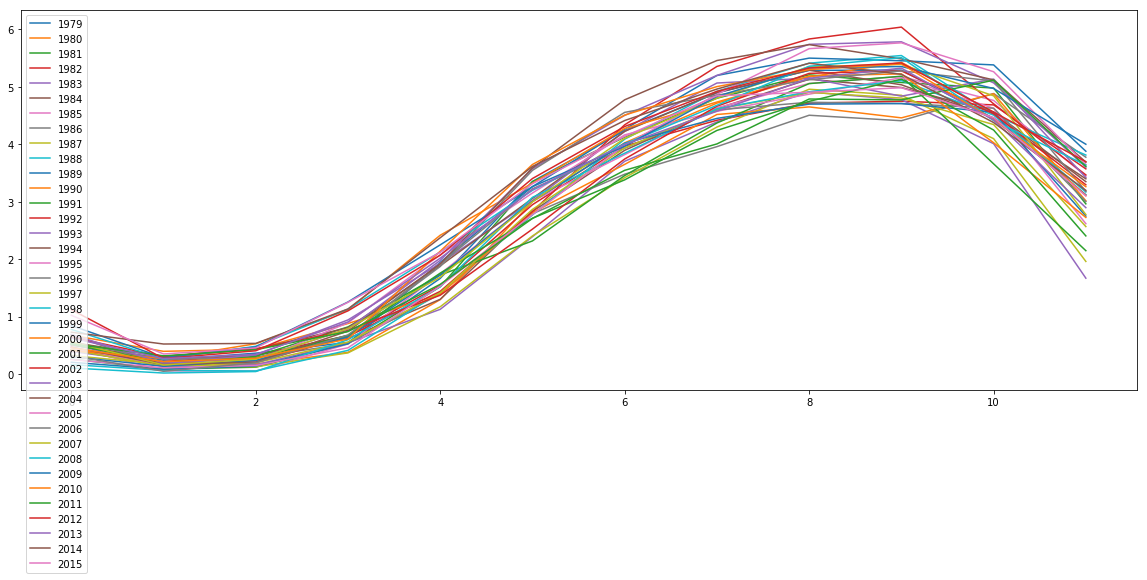

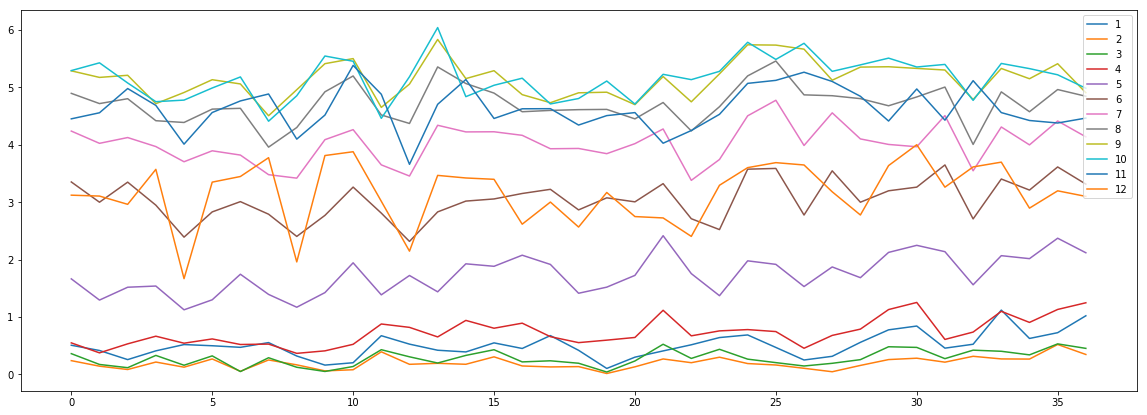

In [8]:


def plot_monthly_means(array, scale=25**2, area=True, extent=False):
    plt.figure(figsize=(20,7))
    mask = array.mask + (array<0.15)
    sic = np.ma.array(array.data, mask=mask)
    if extent:
        sic = np.where(sic.mask==True, 0, 1)
    sic_mean = []
    for i in range(37):
        sic_monthly = sic[i,:,:,:]
        sic_mean = np.array(map(lambda x: np.ma.sum(x) * scale/ 1e6, sic_monthly[:]))
        plt.plot(sic_mean, label=i+1979)
    plt.legend(loc='upper left')    
    plt.show()

def plot_years(array, scale=25**2, area=True, extent=False, export_file=None):
    plt.figure(figsize=(20,7))
    mask = array.mask + (array<0.15)
    sic = np.ma.array(array.data, mask=mask)
    if extent:
        sic = np.where(sic.mask==True, 0, 1)
    sic_mean = []
    mean_sic_array = np.empty(shape=(37,12))
    # f, axarr = plt.subplots(12, 1, figsize=(30,10))
    for i in range(12):
        sic_monthly = sic[:,i,:,:]
        sic_mean = np.array(map(lambda x: np.ma.sum(x) * scale/ 1e6, sic_monthly[:]))
        mean_sic_array[:,i] = sic_mean
        plt.plot(sic_mean, label=i+1)
    
    if export_file:
        np.savetxt(export_file, mean_sic_array, delimiter=";", fmt="%1.3f")
    plt.legend(loc='upper right')    
    plt.show()    
    
filepath = "/media/DataLocal/Projects/DmlEnvironmentState/data/anomalies/out.nc"
dst = nc.Dataset(filepath, 'r')
sic = dst.variables['goddard_merged_seaice_conc_monthly'][:]
lons = dst.variables['longitude'][:]
lon_mask = (lons >= 45) + (lons <= -20)
sic = np.ma.array(sic, mask=np.tile(lon_mask, (37, 12, 1)))
plot_monthly_means(sic, extent=True)
plot_years(sic, extent=True, export_file='out.csv')

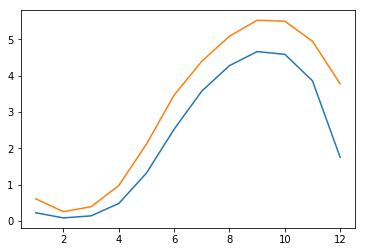

In [5]:
# Mean area and extent
filepath = "/media/DataLocal/Projects/DmlEnvironmentState/data/anomalies/monthly_seaice_conc_merged.nc"
dst = nc.Dataset(filepath, 'r')
sic = dst.variables['goddard_merged_seaice_conc_monthly'][:]
lons = dst.variables['longitude'][:]
lon_mask = (lons >= 40) + (lons <= -25)
sic = np.ma.array(sic, mask=np.tile(lon_mask, (sic.shape[0],1)))
plot_area_timeseries(sic)